In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Visualizing the data

__Author:__ Ji Won Park (@jiwoncpark)

__Created:__ 3/08/2021

__Last run:__ 4/12/2021

__Goals:__
We visualize the input graph.

__Before_running:__
Generate the labels with explicit kappa sampling (moving the constituent halos around in each sightline field of view (FOV) multiple times and evaluating kappa at the center), e.g.
```python
kappa_sampler = CosmoDC2Raytracer(in_dir=IN_DIR,
                                  out_dir='../kappa_sampling',
                                  fov=0.85,
                                  healpix=10450,
                                  n_sightlines=1000,  # keep this small
                                  mass_cut=11.0,
                                  n_kappa_samples=1000)
kappa_sampler.parallel_raytrace()
kappa_sampler.apply_calibration()
```

So that we won't have to explicitly sample kappa every time, we will use Gaussian process regression to infer the spread in kappa for the weighted sum of masses of each sightline.

In [3]:
from n2j.trainval_data.raytracers.cosmodc2_raytracer import CosmoDC2Raytracer

IN_DIR = '../n2j/data'  # where raw data lies
TRAIN_HP = [10327]
N_TRAIN = 1000
BATCH_SIZE = min(N_TRAIN//5, 25)
    
# Use this to infer the mean kappa contribution of new sightlines
for hp in TRAIN_HP:
    train_Y_generator = CosmoDC2Raytracer(in_dir=IN_DIR,
                                          out_dir=f'../demo_Y_{hp}',
                                          kappa_sampling_dir='../kappa_sampling',
                                          fov=0.85,
                                          healpix=hp,
                                          n_sightlines=N_TRAIN,
                                          mass_cut=11.0,
                                          n_kappa_samples=0)  # no sampling
    train_Y_generator.parallel_raytrace()
    train_Y_generator.apply_calibration()

100%|██████████| 1000/1000 [00:04<00:00, 210.83it/s]
/home/jwp/miniconda3/envs/n2j/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Now we build graphs for these 100 sightlines we just computed labels for.

In [4]:
from n2j.trainval_data.graphs.cosmodc2_graph import CosmoDC2Graph
# Features to compile
features = ['ra', 'dec', 'galaxy_id', 'redshift']
features += ['ra_true', 'dec_true', 'redshift_true']
features += ['ellipticity_1_true', 'ellipticity_2_true']
features += ['bulge_to_total_ratio_i', 'ellipticity_1_bulge_true', 'ellipticity_1_disk_true',
             'ellipticity_2_bulge_true', 'ellipticity_2_disk_true', ]
features += ['shear1', 'shear2', 'convergence']
features += ['size_bulge_true', 'size_disk_true', 'size_true']
features += ['mag_{:s}_lsst'.format(b) for b in 'ugrizY']

train_XY = CosmoDC2Graph(in_dir=IN_DIR, 
                         healpixes=TRAIN_HP, 
                         raytracing_out_dirs=[f'../demo_Y_{hp}' for hp in TRAIN_HP], 
                         aperture_size=1.0,
                         n_data=[100], 
                         features=features, 
                         stop_mean_std_early=False)

Which sightlines should we plot? Maybe we want to check out the overdense ones, with high $\kappa$.

In [5]:
for i in range(100):
    if train_XY[i].y[0, 0] > 0.05:
        print(i, train_XY[i].y)

14 tensor([[ 0.0661, -0.0469,  0.0368]])
27 tensor([[ 0.0587, -0.0226,  0.0618]])
29 tensor([[ 0.0521, -0.0323,  0.0791]])
86 tensor([[ 0.0604, -0.0043,  0.0113]])
89 tensor([[ 0.1020,  0.0165, -0.0407]])


Let's now color the nodes by the redshift.

In [6]:
pointings = train_XY.Y

2.0058741569519043


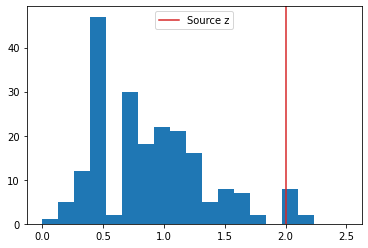

In [20]:
data_i = 89
sample_data = train_XY[data_i]
z_src = pointings.iloc[data_i]['z']
print(z_src)
z = sample_data.x[:, 3].numpy()
z[0] = z_src
plt.hist(z, bins=np.linspace(0, 2.5, 20))
plt.axvline(z_src, color='tab:red', label='Source z')
plt.legend()

torch.Size([208, 26]) torch.Size([2, 3])
tensor([[ 0.1020,  0.0165, -0.0407]])


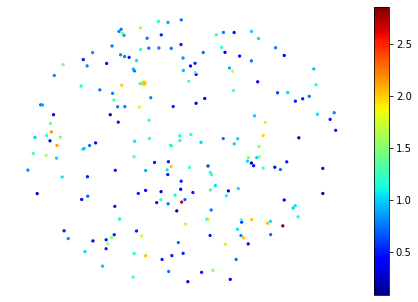

In [23]:
from torch_geometric.utils import to_networkx
import torch
import networkx as nx
import matplotlib

data_i = 89
cmap = matplotlib.cm.get_cmap('jet')
sample_data = train_XY[data_i]
sample_data.edge_index = torch.arange(6).reshape(2, 3)
sample_networkx = to_networkx(sample_data)
n_nodes = sample_data.x.shape[0]
# Color by redshift
z = sample_data.x[:, 3].numpy()
z[0] = pointings.iloc[data_i]['z']
scaled_z = (z - z.min())/(z.max() - z.min())  # scale 0 to 1 for colormap
node_color = cmap(scaled_z)
# Make sightline node bigger
node_size = np.ones(n_nodes)*5
node_size[0] = 20
nx.draw(sample_networkx, pos=dict(zip(range(n_nodes), sample_data.x[:, 4:6].tolist())),
        width=0.2, alpha=1.0, arrowsize=0.0,
        node_color=node_color, node_size=node_size)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=z.min(), vmax=z.max()))
sm.set_array([])
plt.colorbar(sm)

print(sample_data.x.shape, sample_data.edge_index.shape)
print(sample_data.y)

We can additionally scale the node size by the (inverse) i-band magnitude.

torch.Size([208, 26]) torch.Size([2, 3])
tensor([[ 0.1020,  0.0165, -0.0407]])


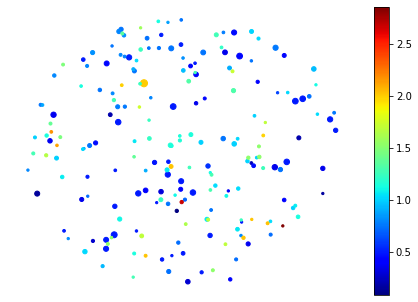

In [22]:
import matplotlib

data_i = 89
cmap = matplotlib.cm.get_cmap('jet')
sample_data = train_XY[data_i]
sample_data.edge_index = torch.arange(6).reshape(2, 3)
sample_networkx = to_networkx(sample_data)
n_nodes = sample_data.x.shape[0]
# Color by redshift
z = sample_data.x[:, 3].numpy()
z[0] = pointings.iloc[data_i]['z']
scaled_z = (z - z.min())/(z.max() - z.min())  # scale 0 to 1 for colormap
node_color = cmap(scaled_z)
# Make brighter nodes bigger
mag = -sample_data.x[:, -3].numpy()
mag[0] = np.mean(mag[1:])
node_size = (mag - mag.min())/(mag.max() - mag.min())*30 + 5
node_size[0] = 50

nx.draw(sample_networkx, pos=dict(zip(range(n_nodes), sample_data.x[:, 4:6].tolist())),
        width=0.2, edge_color='tab:gray', arrowsize=0.0, alpha=1.0, 
        node_color=node_color, node_size=node_size)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=z.min(), vmax=z.max()))
sm.set_array([])
plt.colorbar(sm)

print(sample_data.x.shape, sample_data.edge_index.shape)
print(sample_data.y)